In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from fitellipse import *

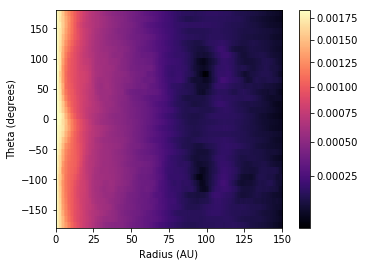

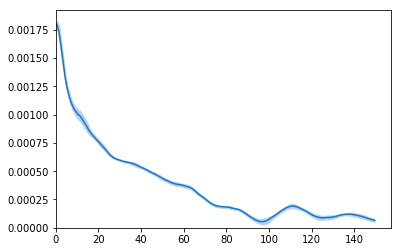

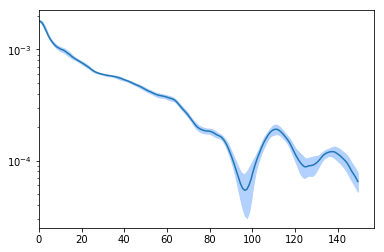

In [3]:
disk = {'filename': '/data/sandrews/ALMA_disks/final_images/DoAr25_script_image.fits',
                          'distance':138,
                          'incl' : 65.8, 
                          'PA' : 110.4, 
                          'offsetx' : 11.1*.003,
                          'offsety' : -162.8*.003,
                          'size': 2.7,
                          'gamma': 0.7,
                         }


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
maxrad = 150
radialbins = 0.5+1*np.arange(maxrad)
_,_, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

surfbrightness, SB_scatter = cont.radialprofile(radialbins, high_incl = True)
plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = disk['gamma']))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.fill_between(radialbins,(surfbrightness - SB_scatter),(surfbrightness + SB_scatter),facecolor = '#B2D1FF',edgecolor = '#B2D1FF')
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.fill_between(radialbins,(surfbrightness - SB_scatter),(surfbrightness + SB_scatter),facecolor = '#B2D1FF',edgecolor = '#B2D1FF')
plt.xlim(xmin = 0)
plt.show()



/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 4.022e-02 arcsec, delta_y = -4.900e-01 arcsec
The MLE semi-major axis is r = 0.702 arcsec
The MLE inclination is i = 67.357 degrees
The MLE position angle is PA = 110.511 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.061e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


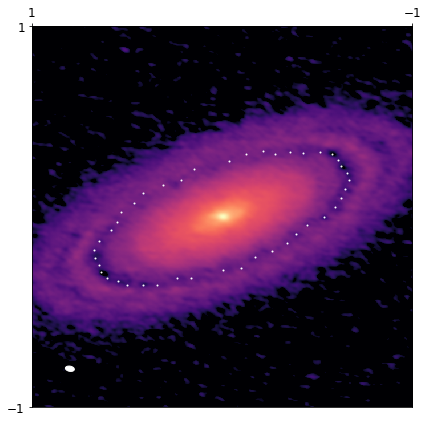

In [15]:

# Extract the gap that's at ~95 AU
xcoords1, ycoords1 = cont.extract_ring(85,105,tbins = -176+8*np.arange(45), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     90/140.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

In [23]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -1<cosi<1 and np.pi/2. < par < 3*np.pi/2. and -15<logvar<-5:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 100
nthreads = 8
nsteps = 2000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

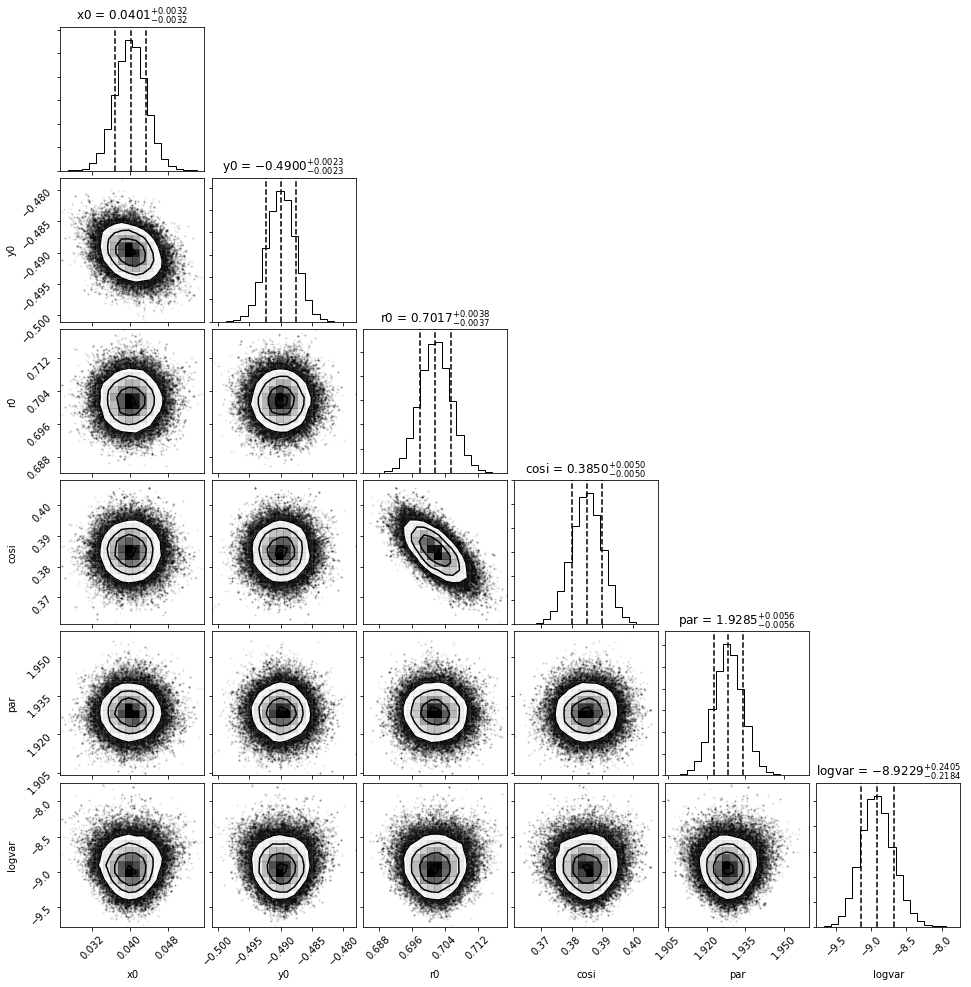

The x offset is delta_x = 4.01e-02 arcsec (+3.2e-03, -3.2e-03)
The y offset is delta_y = -4.90e-01 arcsec (+2.3e-03, -2.3e-03)
The median semi-major axis is r = 0.7017 arcsec (+0.0038, -0.0037) 
or 96.84 AU (+0.32, -0.32)
The incl is i = 67.35 deg (+0.31, -0.31)
The median position angle is PA = 110.50 deg (+0.32, -0.32)
The median log-variance in the pixel offsets from the true ellipse is -8.923e+00


In [24]:

plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.473e-02 arcsec, delta_y = -4.926e-01 arcsec
The MLE semi-major axis is r = 0.804 arcsec
The MLE inclination is i = 66.093 degrees
The MLE position angle is PA = 110.128 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.042e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


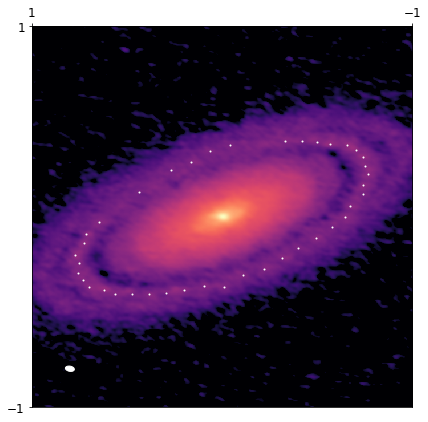

In [29]:

# Extract the ring that's at 110 AU
xcoords2, ycoords2 = cont.extract_ring(105,120,tbins = -176+8*np.arange(45), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     100/140.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)

In [25]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

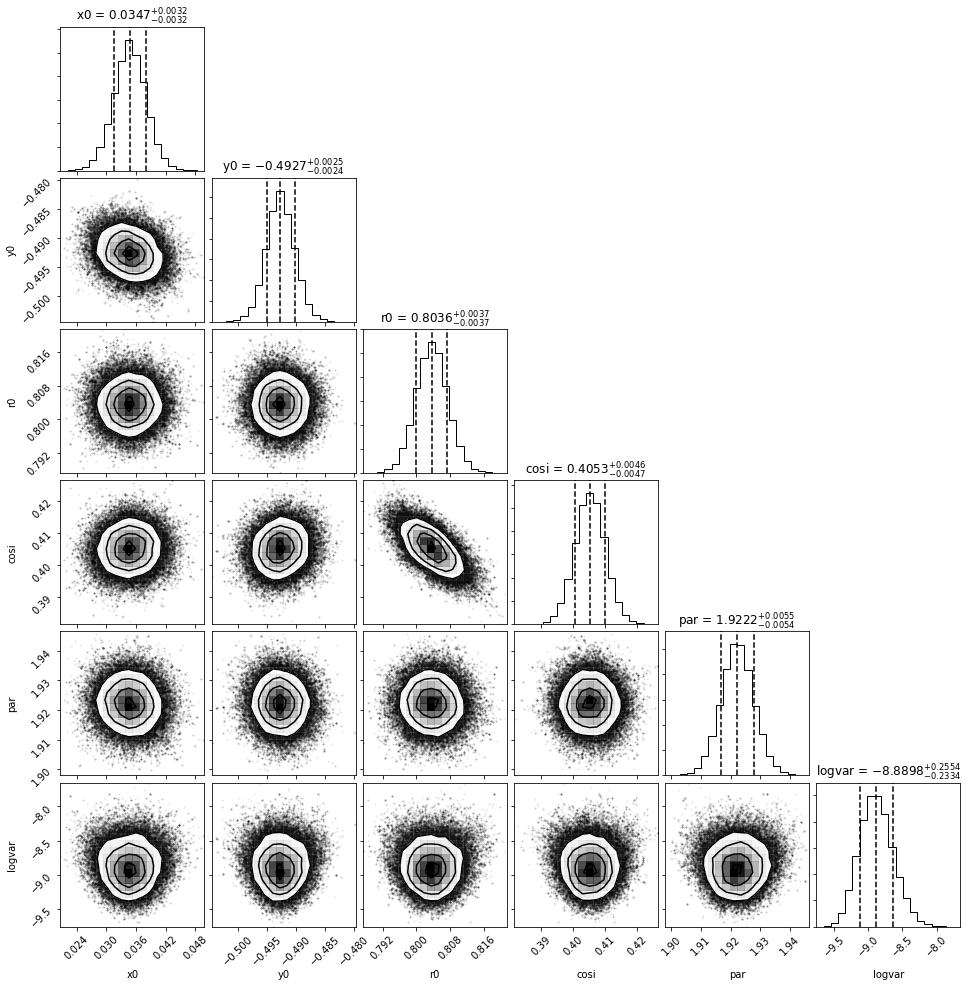

The x offset is delta_x = 3.47e-02 arcsec (+3.2e-03, -3.2e-03)
The y offset is delta_y = -4.93e-01 arcsec (+2.5e-03, -2.4e-03)
The median semi-major axis is r = 0.8036 arcsec (+0.0037, -0.0037) 
or 110.90 AU (+0.34, -0.33)
The incl is i = 66.09 deg (+0.29, -0.29)
The median position angle is PA = 110.14 deg (+0.32, -0.31)
The median log-variance in the pixel offsets from the true ellipse is -8.890e+00


In [26]:

plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)

In [8]:
#make some preliminary plots
newcont = Continuum(disk['filename'], 0.0374,-0.491, 110.3, 66.8,disk['distance'])
    
_, _, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

newsurfbrightness, newSB_scatter = cont.radialprofile(radialbins, high_incl = True)

print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [111, 137]
min [96, 125]


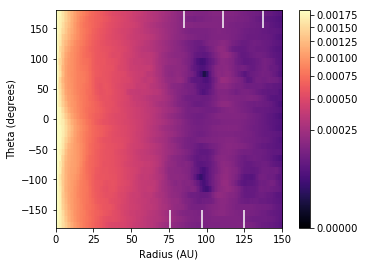

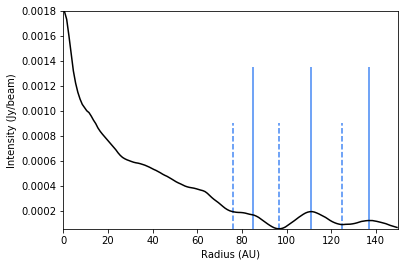

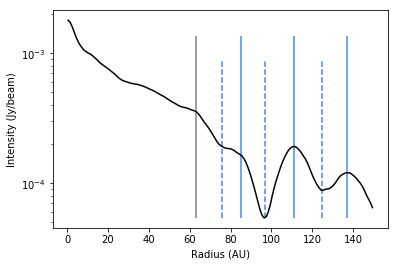

(0, 150)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


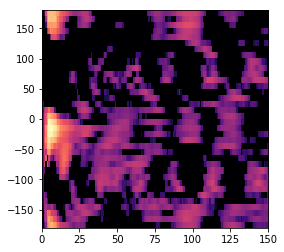

In [15]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
features = np.array([63])
gaps = np.array([76,96.8,125])
rings = np.array([85,110.9,137])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
for f in features:
    plt.vlines(f,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='gray')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.percentile(newrtmap, 50, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
